# One-class Classification : Local Outlier Factor (LOF)

In [12]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score,recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
import time

In [13]:
#Default hyperparameters#
N_NEIGHBORS = 100
LOCAL_OUTLIER_FACTOR_THRESHOLD = 1.5
#################

### Local Outlier Factor Classification : Algorithm

In [14]:
class LocalOutlierFactor:
    def __init__(self, n_neighbors=N_NEIGHBORS,local_outlier_factor_threshold=LOCAL_OUTLIER_FACTOR_THRESHOLD, eps = 1E-30):
        self.n_neighbors = n_neighbors
        self.local_outlier_factor_threshold = local_outlier_factor_threshold
        self.eps = eps
        self.neighbors = NearestNeighbors(n_neighbors=self.n_neighbors + 1) # one additional neighbor for finding the k neighbors of points in the training dataset excluding itself 
    
    def fit(self, train_oneclassdata):
        self.train_oneclassdata = np.unique(train_oneclassdata, axis=0)
        self.neighbors.fit(self.train_oneclassdata)
        self.k_distance_list = self.k_distance_and_indices(self.train_oneclassdata,withinDataset=True)[0][:,-1]
        self.neighborhood_density_list = self.calculate_neighborhood_density(self.train_oneclassdata)
        return self
    
    def k_distance_and_indices(self, X, withinDataset = False):
        distances, indices = self.neighbors.kneighbors(X)
        if(withinDataset):
            return distances[:,1:], indices[:,1:]
        else:
            return distances[:,:-1],indices[:,:-1]
    
    def calculate_neighborhood_density(self,X):
        k_distances, k_nearest_neighbours = self.k_distance_and_indices(X)
        k_d_reach =  np.maximum(k_distances,self.k_distance_list[k_nearest_neighbours])
        neighborhood_density = (self.n_neighbors * 1.0)/(np.sum(k_d_reach,axis=-1)+self.eps)        
        return neighborhood_density
    
    def calculate_local_outlier_factor(self, X):
        neighbors = self.k_distance_and_indices(X)[1]
        neighborhood_density = self.calculate_neighborhood_density(X)
        localOutlierFactor = np.mean(self.neighborhood_density_list[neighbors],axis=-1)/neighborhood_density
        return localOutlierFactor
        
    def predict(self,X):
        return self.calculate_local_outlier_factor(X) > self.local_outlier_factor_threshold

### Evaluation function

In [15]:
def evaluate(csv_file_path, ycolname):
    df = pd.read_csv(csv_file_path)
    time_start = time.time()   
    trainx, testx, trainy, testy = train_test_split(df.drop([ycolname], axis=1).values, df[ycolname].values, test_size=0.2,random_state=42)
    localOutlierFactorClassifier = LocalOutlierFactor(n_neighbors=N_NEIGHBORS,local_outlier_factor_threshold=LOCAL_OUTLIER_FACTOR_THRESHOLD).fit(trainx[trainy == 0])

    #prediction
    testy_pred = localOutlierFactorClassifier.predict(testx)

    #show confusion matrix to check directional accuracy
    cm = confusion_matrix(testy>0, testy_pred>0)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Inlier','Outlier'])
    disp.plot()
    print("Outlier predictions:",np.sum(testy_pred>0))
    print("Inlier predictions:",np.sum(testy_pred<=0))
    print("Outlier actuals:",np.sum(testy>0))
    print("Inlier actuals:",np.sum(testy<=0))
    print(f'Accuracy score: {accuracy_score(testy>0, testy_pred>0) :>.3%}')
    print(f'Precision score: {precision_score(testy>0, testy_pred>0) :>.3%}')
    print(f'Recall score: {recall_score(testy>0, testy_pred>0) :>.3%}')
    print(f'F1 score: {f1_score(testy>0, testy_pred>0) :>.3%}')
    time_end = time.time()
    print("Time taken:",time_end-time_start)
    plt.show()

### Evaluation on Dataset 1 : 'http.csv'

Outlier predictions: 461
Inlier predictions: 113039
Outlier actuals: 445
Inlier actuals: 113055
Accuracy score: 99.984%
Precision score: 96.312%
Recall score: 99.775%
F1 score: 98.013%
Time taken: 10.097622394561768


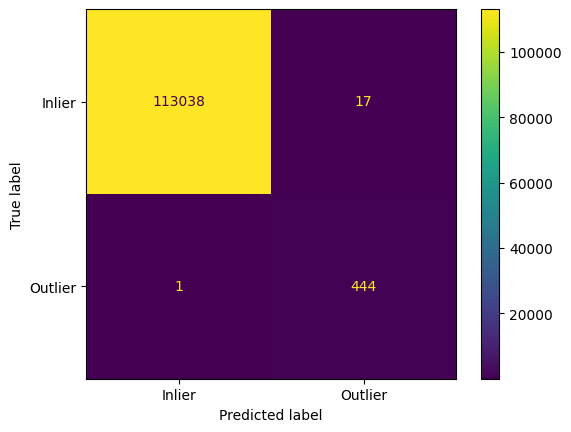

In [16]:
#Application-specific hyperparameters#
N_NEIGHBORS = 100
LOCAL_OUTLIER_FACTOR_THRESHOLD = 4
#################

evaluate('http.csv','attack')

### Evaluation on Dataset 2 : 'cancer.csv'

Outlier predictions: 40
Inlier predictions: 74
Outlier actuals: 43
Inlier actuals: 71
Accuracy score: 92.105%
Precision score: 92.500%
Recall score: 86.047%
F1 score: 89.157%
Time taken: 0.156113862991333


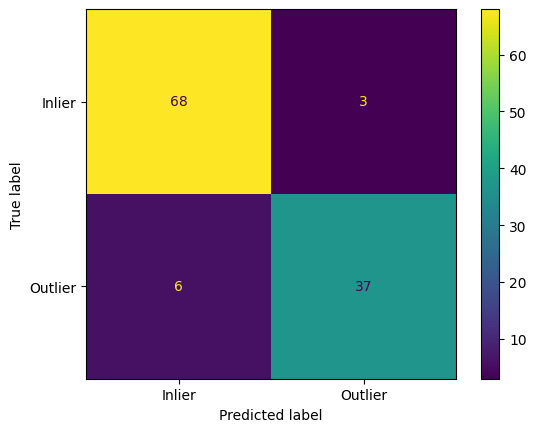

In [17]:
#Application-specific hyperparameters#
N_NEIGHBORS = 100
LOCAL_OUTLIER_FACTOR_THRESHOLD = 1.5
#################

evaluate('cancer.csv','diagnosis')